In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from attrbench import datasets, attribution, models
from attrbench.evaluation.infidelity import infidelity
import itertools
from os import path
import pandas as pd
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [3]:
# General parameters
batch_size = 16
n_batches = 4
n_perturbations = 16
data_root = "../data"
use_logits = True
dataset_name = "MNIST"
normalize_attrs = True
aggregation_fn = "avg"
device = "cuda"

In [4]:
# CIFAR10 parameters
if dataset_name == "CIFAR10":
    dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, "CIFAR10"), download=False, shuffle=False, version="cifar10")
    model = models.Resnet(version="resnet18", output_logits=use_logits, num_classes=10, params_loc=path.join(data_root, "models/CIFAR10/resnet18.pth"))
    model.eval()
    model.to(device)

In [5]:
# MNIST parameters
if dataset_name == "MNIST":
    dataset = datasets.MNIST(batch_size=batch_size, data_location=path.join(data_root, "MNIST"), download=False, shuffle=False)
    model = models.BasicCNN(params_loc=path.join(data_root, "models/MNIST/cnn.pt"), output_logits=use_logits, num_classes =10)
    model.eval()
    model.to(device)

In [6]:
kwargs = {
    "normalize": normalize_attrs,
    "aggregation_fn": aggregation_fn

}

attribution_methods = {
    "GuidedGradCAM": attribution.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": attribution.Gradient(model, **kwargs),
    "InputXGradient": attribution.InputXGradient(model, **kwargs),
    "IntegratedGradients": attribution.IntegratedGradients(model, **kwargs),
    "GuidedBackprop": attribution.GuidedBackprop(model, **kwargs),
    "Deconvolution": attribution.Deconvolution(model, **kwargs),
}

In [7]:
result = infidelity(data=itertools.islice(dataset.get_dataloader(train=False), n_batches), model=model,
                    methods=attribution_methods, n_perturbations=n_perturbations, pixel_level=normalize_attrs,
                    device=device)

0it [00:00, ?it/s]/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.7/site-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
/home/arne/Documents/PhD/projects/benchmark/venv/lib/python3.7/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:56: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  "Setting backward hooks on ReLU activations."
4it [00:00,  9.20it/s]


In [13]:
result_df = pd.DataFrame.from_dict(
    {m_name: pd.Series(data=result[m_name]) for m_name in attribution_methods}
).stack().reset_index()
result_df.columns = ["sample", "method", "infidelity"]

In [14]:
result_df

,sample,method,infidelity
0,0,GuidedGradCAM,2.072929
1,0,Gradient,0.321265
2,0,InputXGradient,2.383844
3,0,IntegratedGradients,2.132578
4,0,GuidedBackprop,3.505853
...,...,...,...
6139,1023,Gradient,0.079927
6140,1023,InputXGradient,0.570859
6141,1023,IntegratedGradients,0.739367
6142,1023,GuidedBackprop,0.009831


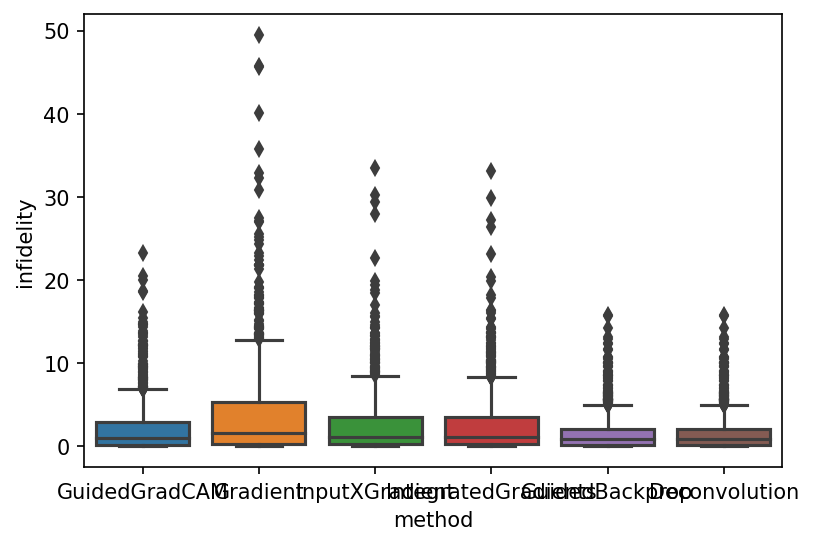

In [16]:
import seaborn as sns
sns.boxplot(x="method", y="infidelity", data=result_df)